# Swiss roll - Standard (Non-Linear) Decoder

Synthetic examples comparing different architectures using the low-level API of Ladder.

## Imports

In [1]:
import torch, pyro, os, re, sys, warnings
import torch.utils.data as utils
import numpy as np
import pandas as pd
from ladder.models import SCVI, SCANVI, Patches, _broadcast_inputs
from ladder.scripts import train_pyro, train_pyro_disjoint_param, get_device, get_reproduction_error

from sklearn.datasets import make_swiss_roll
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import math
import anndata as ad
import scanpy as sc

%matplotlib inline

np.random.seed(42)
torch.manual_seed(42)
pyro.util.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gamma_apr = np.round((1.-math.gamma(1+1.e-8))*1.e14 )*1.e-6

#device="cpu"

reducer = umap.UMAP(metric="euclidean", random_state=42, n_neighbors=100, min_dist=0.1)
warnings.filterwarnings('ignore')


print(f"Device: {device}")

Device: cuda


In [2]:
# Helpers for basic plots
def _transform_labels(labels):
    return torch.hstack((labels[:,:2].argmax(-1).view(-1,1), labels[:,2:].argmax(-1).view(-1,1)))

def get_labels(labels):
    labs = _transform_labels(labels)
    df = pd.DataFrame(labs)
    df["comb"] = df.apply(lambda x : str(x[0]) + "," + str(x[1]), axis = 1)
    return torch.tensor(pd.get_dummies(df["comb"]).astype(int).to_numpy())


#################### DATASET PARAMS #########################################################################################
n=2000  # Number of points in each attribute combination
batch_size=64 # Loader batch size
z_dim, w_dim=10, 10  # Latent dims of attributes and half dim of outputs
z_mean, z_std=0, 1  # Common latent parameters (gaussian)
a_10_mean, a_10_std, a_11_mean, a_11_std=0, 1, -1.15, 1  # Attribute 1 parameters: a10 --> Attribute 1 Off //  a11 --> Attribute 1 On // Parameters for respective gaussians
a_20_mean, a_20_std, a_21_mean, a_21_std=0, 1, 1.15, 1  # Attribute 2 parameters: a20 --> Attribute 2 Off // a21 --> Attribute 2 On // Parameters for respective gaussians
##################################################################################################################################

# Generate dataset
## Common
z_s = torch.normal(z_mean, z_std, size=(n*4, z_dim))


## Specific
w_0_0 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_0_1 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)
w_1_0 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_1_1 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)

## Combine Ws
w_s = torch.concat((w_0_0, w_0_1, w_1_0, w_1_1))

## Combine into full latents
data = torch.concat((z_s, w_s), dim=-1)

## Label Setup
labels = torch.concat((torch.tensor([1,0,1,0]).repeat((n,1)), torch.tensor([1,0,0,1]).repeat((n,1)), torch.tensor([0,1,1,0]).repeat((n,1)), torch.tensor([0,1,0,1]).repeat((n,1))))
labels_one_hot = torch.concat((torch.tensor([1,0,0,0]).repeat((n,1)), torch.tensor([0,1,0,0]).repeat((n,1)), torch.tensor([0,0,1,0]).repeat((n,1)), torch.tensor([0,0,0,1]).repeat((n,1))))


# Datasets & Loaders Setup
dataset = utils.TensorDataset(data.double(), labels.double(), labels.double())
dataset_one_hot = utils.TensorDataset(data.double(), labels_one_hot.double(), labels.double())
train_set, test_set = utils.random_split(dataset, [0.8, 0.2])
train_set_oh, test_set_oh = utils.random_split(dataset_one_hot, [0.8, 0.2])
train_loader, test_loader = utils.DataLoader(train_set, num_workers=4, batch_size=batch_size, shuffle=True), utils.DataLoader(test_set, num_workers=4, batch_size=batch_size, shuffle=False)
train_loader_oh, test_loader_oh = utils.DataLoader(train_set_oh, num_workers=4, batch_size=batch_size, shuffle=True), utils.DataLoader(test_set_oh, num_workers=4, batch_size=batch_size, shuffle=False)

## Toy Dataset - Swiss Roll

Recreation of the swiss roll example from the original CSVAE paper.

In [3]:
#################### DATASET PARAMS #########################################################################################
n=10000  # Number of points for the roll
batch_size=64 # Loader batch size
##################################################################################################################################


xs, _ = make_swiss_roll(n)
xs = torch.DoubleTensor(xs)
ys = torch.nn.functional.one_hot((xs[:, 1] < 10).type(torch.long)).double()
xs = (xs - np.array([xs[:,0].min() - 5, -5, xs[:,2].min() - 5])) # Shift to make entries non-negative
dataset = utils.TensorDataset(xs, ys, ys) # Duplicate ys, needed for workflow
train_set, test_set = dataset, utils.TensorDataset(*dataset[:batch_size]) # No test set  
train_loader, test_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size), torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size) # Test is dummy

run = 'roll'

## Dataset Visualization

Visually understanding the dataset generated in the previous step.

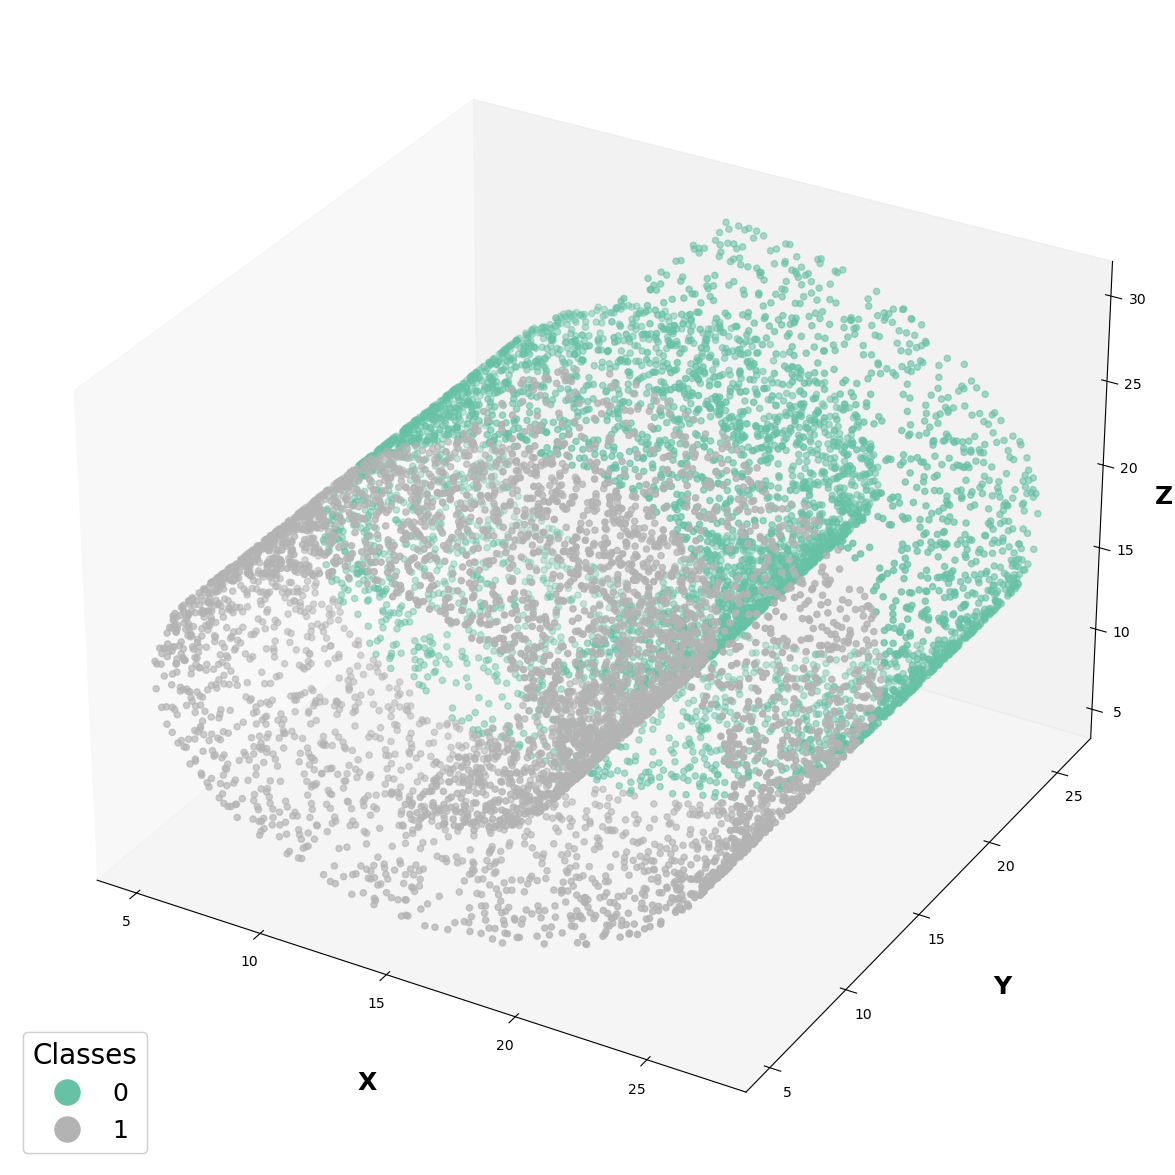

In [4]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(dataset[:][0][:,0], dataset[:][0][:,1] ,dataset[:][0][:,2], c=ys.argmax(-1), cmap="Set2")

elems = list(scatter.legend_elements())
legend = ax.legend(*elems,
               loc="lower left", 
               title="Classes",
               title_fontsize=20,
               fontsize=18,
                markerscale=3)

ax.add_artist(legend)
ax.grid(False)

ax.set_xlabel('X', weight='bold', labelpad=30, fontsize=18)
ax.set_ylabel('Y', weight='bold', labelpad=30, fontsize=18)
ax.set_zlabel('Z', weight='bold', labelpad=7, fontsize=18)

#fig.savefig("swiss_roll.png", dpi=300, bbox_inches="tight")


plt.show()

## Model

In [5]:
l_mean, l_scale = train_set[:][0].sum(-1).log().mean(), train_set[:][0].sum(-1).log().var()  #Ignored but needed for params
len_attrs = [2]

pyro.clear_param_store()

patches = Patches(
    num_genes=train_set[0][0].shape[0],
    num_labels=sum(len_attrs),
    l_loc=l_mean,
    l_scale=l_scale,
    len_attrs=len_attrs, betas = [1],
    scale_factor=1.0 / (batch_size * train_set[0][0].shape[0]), 
    batch_correction=False,
    reconstruction='Normal',
    latent_dim=2,
    w_dim=1,
    num_layers=4,
    recon_weight=20,
    w_kl=1,
    z_kl=0.2,
    ).double()

patches, train_loss, test_loss, param_nonc_names, param_c_names =\
train_pyro_disjoint_param(patches, 
                          train_loader=train_loader, 
                          test_loader=test_loader, 
                          verbose=False, 
                          num_epochs=300,
                          convergence_window=10000,
                          optim_args={
                            "optim_args": {"lr": 1e-3, "eps": 1e-2, "betas": (0.9, 0.999)},   # Since we normalize by the 
                            "gamma": 0.14,
                            "milestones": [],
                          },)

Using device: cuda



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [39:27<00:00,  7.89s/it]


In [6]:
patches = patches.cpu()
patches.eval()
predictive = pyro.infer.Predictive(patches.generate, num_samples=1)

## Reconstruction

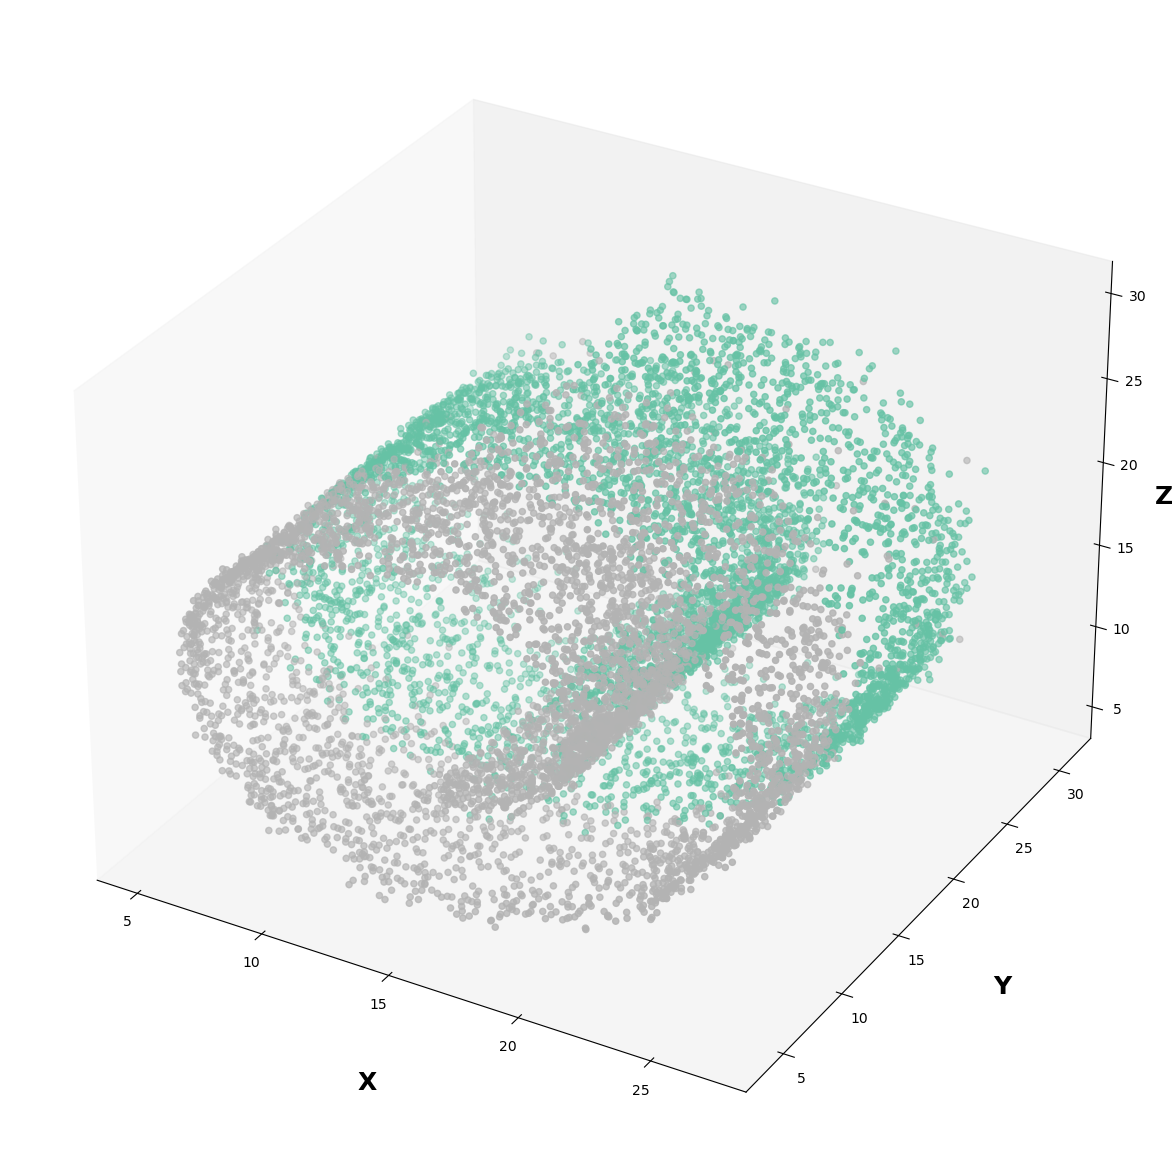

In [7]:
rec = predictive(dataset[:][0], dataset[:][1], dataset[:][2])['x']
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(rec[:][0][:,0], rec[:][0][:,1] ,rec[:][0][:,2], c=dataset[:][1].argmax(-1), cmap="Set2")
ax.grid(False)

ax.set_xlabel('X', weight='bold', labelpad=30, fontsize=18)
ax.set_ylabel('Y', weight='bold', labelpad=30, fontsize=18)
ax.set_zlabel('Z', weight='bold', labelpad=7, fontsize=18)

fig.savefig("swiss_roll_reconstructed.png", dpi=300, bbox_inches="tight")





plt.show()

## Latent Components

In [8]:
rho_latent = patches.rho_l_encoder(dataset[:][0])[0]
rho_y = _broadcast_inputs([rho_latent, dataset[:][1]])
rho_y = torch.cat(rho_y, dim=-1)


w_latent = patches.w_encoder(rho_y)[0]
z_latent = patches.z_encoder(rho_latent)[0]

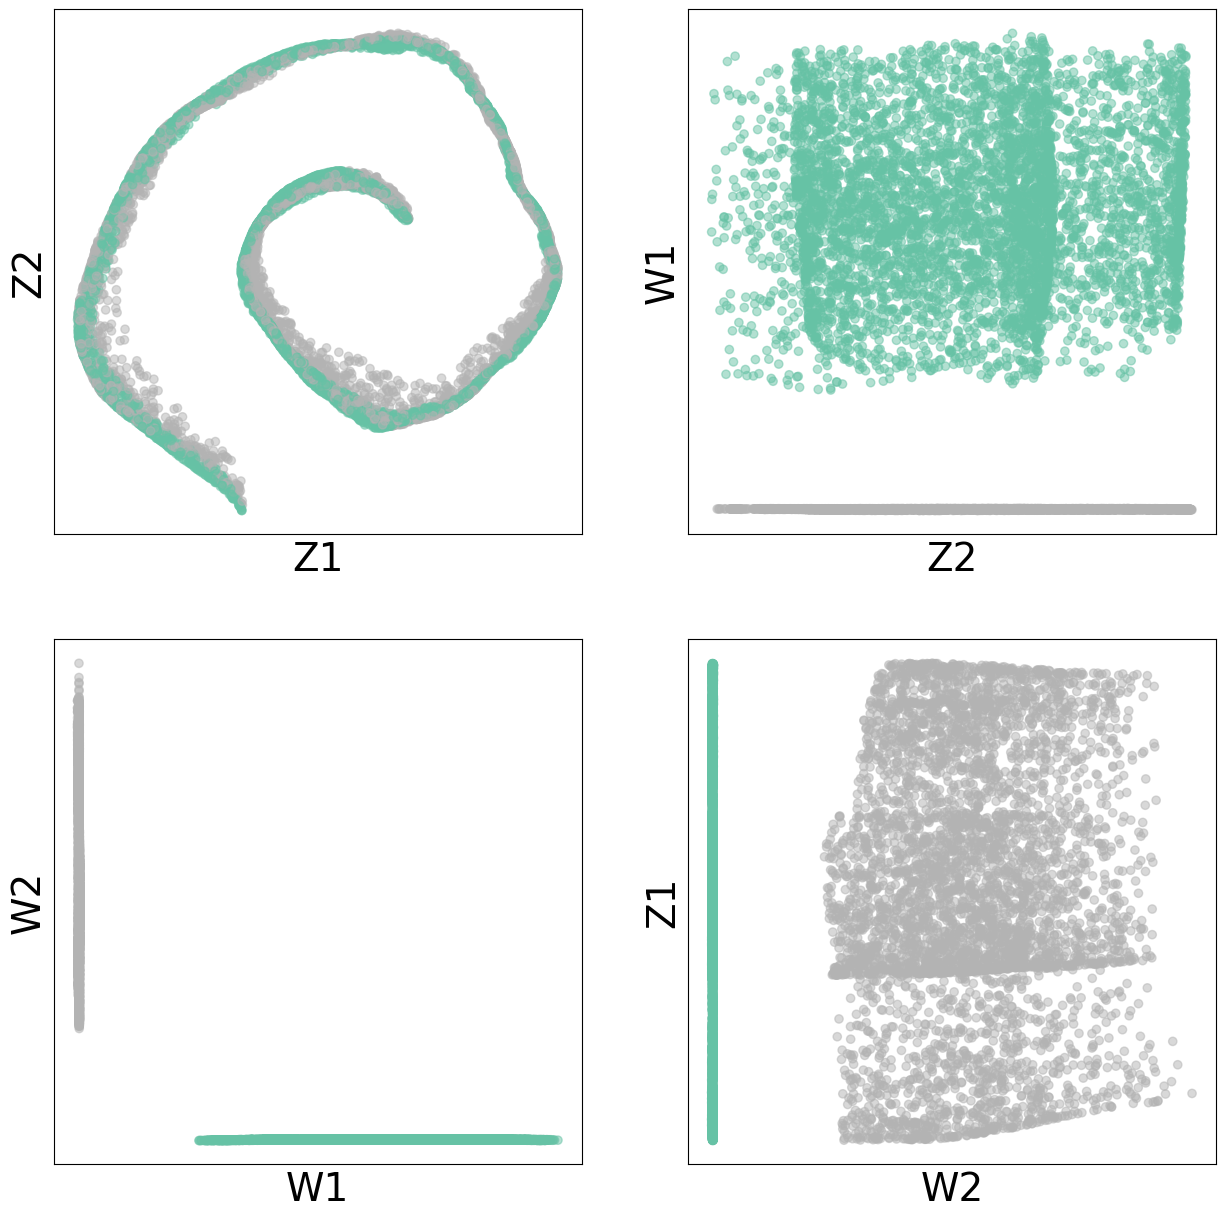

In [9]:
ax_order = [["Z1", "Z2"], ["Z2",  "W1"], ["W1", "W2"], ["W2", "Z1"]]
lat_match = {
    "Z1" : z_latent[:,0].detach(),
    "Z2" : z_latent[:,1].detach(),
    "W1" : w_latent[:,0].detach(),
    "W2" : w_latent[:,1].detach(),
}
fig,ax = plt.subplots(2, 2, figsize=(15,15))


for i in range(len(ax_order)):
    cur_ax = ax[i//2][i%2]
    x_n, y_n = ax_order[i][0], ax_order[i][1]
    x, y = lat_match[x_n], lat_match[y_n]
    
    cur_ax.scatter(x, y, c=ys.argmax(-1), alpha=0.5, cmap="Set2")
    cur_ax.set_xlabel(x_n, fontsize=28)
    cur_ax.set_ylabel(y_n, fontsize=28)
    cur_ax.set_xticklabels([])
    cur_ax.set_yticklabels([])
    cur_ax.set_xticks([])
    cur_ax.set_yticks([])
    cur_ax.set_facecolor('white')
    
    
    for spine in cur_ax.spines.values():
            spine.set_edgecolor('black')


plt.show()